In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import time
from notebook_init import *

out_root = Path('out/1dim')
makedirs(out_root, exist_ok=True)
rand = lambda : np.random.randint(np.iinfo(np.int32).max)
torch.autograd.set_grad_enabled(True)

In [2]:
use_w = True
dataset = 'ffhq'
inst = get_instrumented_model('StyleGAN2', dataset, 'style', device, inst=inst, use_w=use_w)
model = inst.model
model.truncation = 1.0

Loading ../models/checkpoints/stylegan2/stylegan2_ffhq_1024.pt


# Verify StyleCLIP Global Direction

In [5]:
seeds = [1334033683,
1189639317,
1816791114,
202834318,
1364111739,
578932924,
2143730011,
280753788,
478538539,
739334749,
1568815802,
143995083,
978064572,
1283977665,
596654801,
1268626098,
857556112,
295899399,
149065492,
984465835,
2123180700,
810812507,
1519866409,
1437158069,
]
seed = seeds[6]

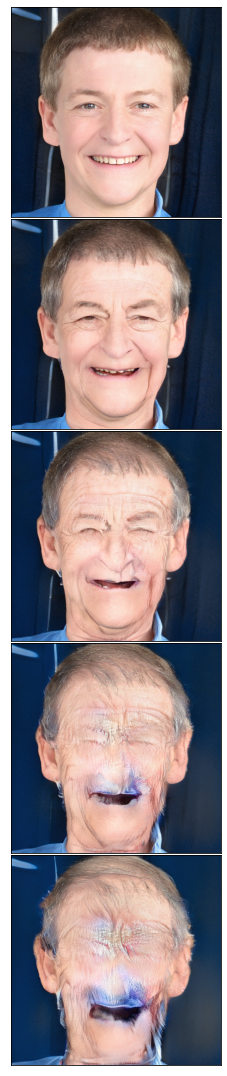

In [6]:
semantic = 'old'
torch.manual_seed(120216)
gd = torch.tensor(np.load(f'global_directions/gd_{semantic}_with_fine.npy'), dtype=torch.float32).to(device)

max_iter = 10
step_size = 2

# StyleCLIP
fig = plt.figure(figsize=(3, 3 * max_iter // 2))
fig.subplots_adjust(left=0.01, bottom=0.01, right=0.99, top=0.99, wspace=0.01, hspace=0.01)
# seed = 366745668
random_state = np.random.RandomState(seed)
noise = torch.from_numpy(
    random_state.standard_normal(512).reshape(1, 512)).float().to(model.device)
#noise = abc.clone().detach()
z_list = []
for _ in range(18):
    z_list.append(model.model.style(noise.clone().detach()))

for t in range(max_iter):
    for i in range(18):
        z_list[i] += 1 * step_size * gd[i].reshape(1, 512)

    if t % 2 != 0:
        continue
    output = model.model.forward(z_list, input_is_w=True)[0]
    image = (0.5 * (output[0] + 1)).detach().cpu()
    image[image > 1] = 1.
    image[image < 0] = 0.
    ax = fig.add_subplot(max_iter // 2, 1, t // 2 + 1)
    ax.imshow(image.permute(1, 2, 0))
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()
fig.savefig(f'img/styleclip_{semantic}_{seed}.png', dpi=100)

# Verify Ours (Stochastic Iterative Traversal 

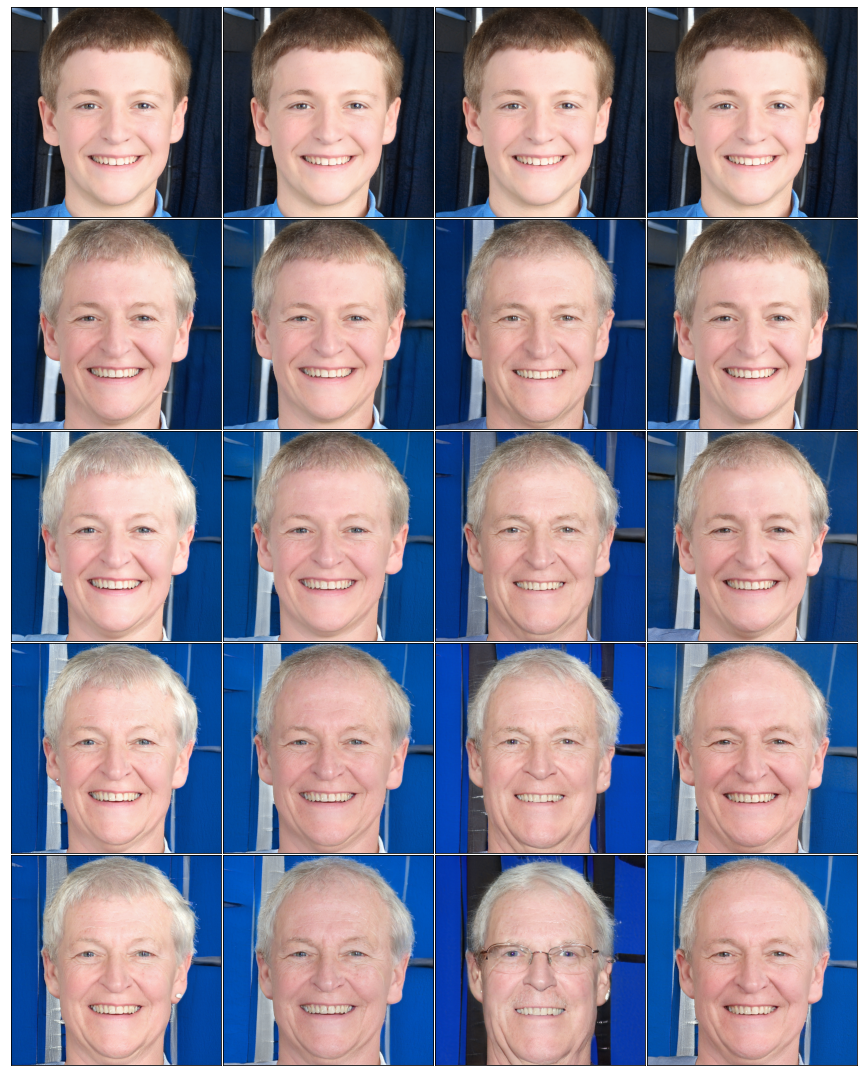

In [7]:
semantic = 'old'
torch.manual_seed(19981005)
gd = torch.tensor(np.load(f'global_directions/gd_{semantic}_with_fine.npy'), dtype=torch.float32).to(device)

# config
stochastic = True # True for "stochastic" ICT, False for "deterministic" (original) ICT
similar_prev = False # True for "following previous basis", False for "following the global guide"
max_iter = 80
step_size = 0.05 # max_iter x step_size is recommended to be about 4 (total perturbation intensity)
show_period = 16 # please set max_iter / 5 (if you want to 5 rows in the output)

k = 100 # how many basis vectors do you want to use? (<= 512)
num_column = 4 # num of columns in the output

# noise
if stochastic:
    a = 0.2 # control this term (negative value is also okay)
    b = 2 - a
else:
    a = 1
    b = 2 - a

fig = plt.figure(figsize=(3 * num_column, 3 * max_iter // show_period))
fig.subplots_adjust(left=0.01, bottom=0.01, right=0.99, top=0.99, wspace=0.01, hspace=0.01)
for c in range(0, num_column):
    
    # not stochastic; green box in Figure 
    if not stochastic:
        if c == 0:
            max_iter = 200
            step_size = 0.02
            show_period = 40
        elif c == 1:
            max_iter = 100
            step_size = 0.04
            show_period = 20
        elif c == 2:
            max_iter = 50
            step_size = 0.08
            show_period = 10
        elif c == 3:
            max_iter = 25
            step_size = 0.16
            show_period = 5
        
    random_state = np.random.RandomState(seed)
    noise = torch.from_numpy(
        random_state.standard_normal(512).reshape(1, 512)).float().to(model.device)
    
    z_list = [model.model.style(noise)] * 18
    
    output = model.model.forward(z_list, input_is_w=True)[0]
    image = (0.5 * (output[0] + 1)).detach().cpu()
    image[image > 1] = 1.
    image[image < 0] = 0.
    ax = fig.add_subplot(max_iter // show_period, num_column, c+1)
    ax.imshow(image.permute(1, 2, 0))
    ax.set_xticks([])
    ax.set_yticks([])
    

    ignore_list = []
    for t in range(1, max_iter):
        noise_pad = noise.repeat(512, 1).requires_grad_(True)
        z_pad = model.model.style(noise_pad)
        grad_output = torch.eye(512).to(device)
        jacobian = torch.autograd.grad(z_pad, noise_pad, grad_outputs=grad_output, retain_graph=True)[0].cpu()
        z_basis, s, noise_basis = torch.svd(jacobian)
        
        noise_change = [0.] * 18
        
        if similar_prev:
            if t == 1: # first iter
                prev_z = []
                for i in range(18):
                    dot = torch.mm(gd[i].reshape(1, 512), z_basis[:, :k].to(device))
                    idx = torch.argmax(torch.abs(dot))
                    if dot[:, idx] > 1e-12:
                        sign = 1
                    elif dot[:, idx] < -1e-12:
                        sign = -1
                    else: # ignore this i-th layer
                        sign = 0
                        ignore_list.append(i)
                    d = sign * noise_basis[:, idx].reshape(1, 512).to(device)
                    variation = (a + (b - a) * torch.rand(1)).to(device)
                    noise_change[i] = step_size * variation * d
                    prev_z.append(z_basis[:, idx].clone())

            else: # after second iter
                for i in range(18):
                    dot = torch.mm(prev_z[i].reshape(1, 512).to(device), z_basis[:, :k].to(device))
                    idx = torch.argmax(torch.abs(dot))
                    if dot[:, idx] > 1e-12:
                        sign = 1
                    elif dot[:, idx] < -1e-12:
                        sign = -1
                        
                    if i in ignore_list:
                        sign = 0
                        
                    d = sign * noise_basis[:, idx].reshape(1, 512).to(device)
                    variation = (a + (b - a) * torch.rand(1)).to(device)
                    noise_change[i] = step_size * variation * d
                    prev_z[i] = z_basis[:, idx].clone()
                    
        else:
            for i in range(18):
                dot = torch.mm(gd[i].reshape(1, 512), z_basis[:, :k].to(device))
                idx = torch.argmax(torch.abs(dot))
                if dot[:, idx] > 1e-12:
                    sign = 1
                elif dot[:, idx] < -1e-12:
                    sign = -1
                else: #negligible change
                    sign = 0
                d = sign * noise_basis[:, idx].reshape(1, 512).to(device)
                variation = (a + (b - a) * torch.rand(1)).to(device)
                noise_change[i] = step_size * variation * d
                
            
        for i in range(18):
            noise += noise_change[i]
            
        if t % show_period != 0:
            continue
            
        z_list = [model.model.style(noise)] * 18
        output = model.model.forward(z_list, input_is_w=True)[0]
        image = (0.5 * (output[0] + 1)).detach().cpu()
        image[image > 1] = 1.
        image[image < 0] = 0.
        ax = fig.add_subplot(max_iter // show_period, num_column, (t // show_period) * num_column + c + 1)
        ax.imshow(image.permute(1, 2, 0))
        ax.set_xticks([])
        ax.set_yticks([])
        
plt.show()
